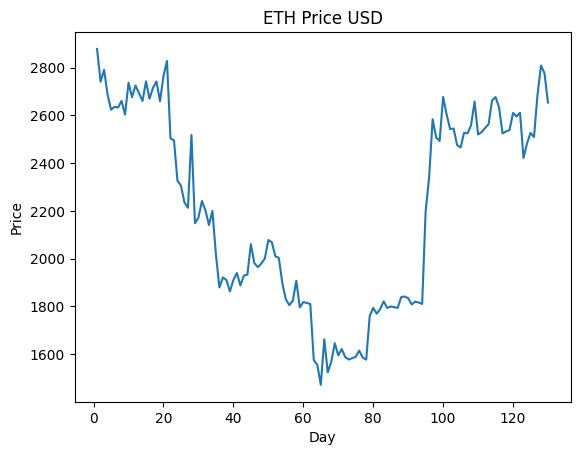

/var/folders/2y/qzbqv0gd2qqgxns0ftqhv27m0000gn/T/ipykernel_23558/1894376305.py:116: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  reverse_df = pd.concat(
/var/folders/2y/qzbqv0gd2qqgxns0ftqhv27m0000gn/T/ipykernel_23558/1894376305.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  deposits_df = pd.concat(
/var/folders/2y/qzbqv0gd2qqgxns0ftqhv27m0000gn/T/ipykernel_23558/1894376305.py:169: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a futu


統計數據 - ForwardDepositProb0.1_SingleSideProb0.5_EthSideProb0.5:
正向存款筆數: 96
反向存款筆數: 904
正向存款總金額: 116693.18 USD
反向存款總金額: 1057090.16 USD
提領筆數: 96
revert_exercise 筆數: 654


/var/folders/2y/qzbqv0gd2qqgxns0ftqhv27m0000gn/T/ipykernel_23558/1894376305.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  deposits_df = pd.concat(
/var/folders/2y/qzbqv0gd2qqgxns0ftqhv27m0000gn/T/ipykernel_23558/1894376305.py:116: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  reverse_df = pd.concat(
/var/folders/2y/qzbqv0gd2qqgxns0ftqhv27m0000gn/T/ipykernel_23558/1894376305.py:169: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a futu


統計數據 - ForwardDepositProb0.5_SingleSideProb0.5_EthSideProb0.5:
正向存款筆數: 528
反向存款筆數: 472
正向存款總金額: 625161.34 USD
反向存款總金額: 555781.99 USD
提領筆數: 528
revert_exercise 筆數: 359


/var/folders/2y/qzbqv0gd2qqgxns0ftqhv27m0000gn/T/ipykernel_23558/1894376305.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  deposits_df = pd.concat(
/var/folders/2y/qzbqv0gd2qqgxns0ftqhv27m0000gn/T/ipykernel_23558/1894376305.py:116: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  reverse_df = pd.concat(
/var/folders/2y/qzbqv0gd2qqgxns0ftqhv27m0000gn/T/ipykernel_23558/1894376305.py:140: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a futu


統計數據 - ForwardDepositProb0.9_SingleSideProb0.5_EthSideProb0.5:
正向存款筆數: 904
反向存款筆數: 96
正向存款總金額: 1048472.11 USD
反向存款總金額: 112287.48 USD
提領筆數: 904
revert_exercise 筆數: 73

所有場景的 K 值變化:
ForwardDepositProb0.1_SingleSideProb0.5_EthSideProb0.5: 初始 K = 5364.53, 最終 K = 4607.91, 變化 = -14.10%
ForwardDepositProb0.5_SingleSideProb0.5_EthSideProb0.5: 初始 K = 5364.53, 最終 K = 5730.29, 變化 = 6.82%
ForwardDepositProb0.9_SingleSideProb0.5_EthSideProb0.5: 初始 K = 5364.53, 最終 K = 6844.28, 變化 = 27.58%


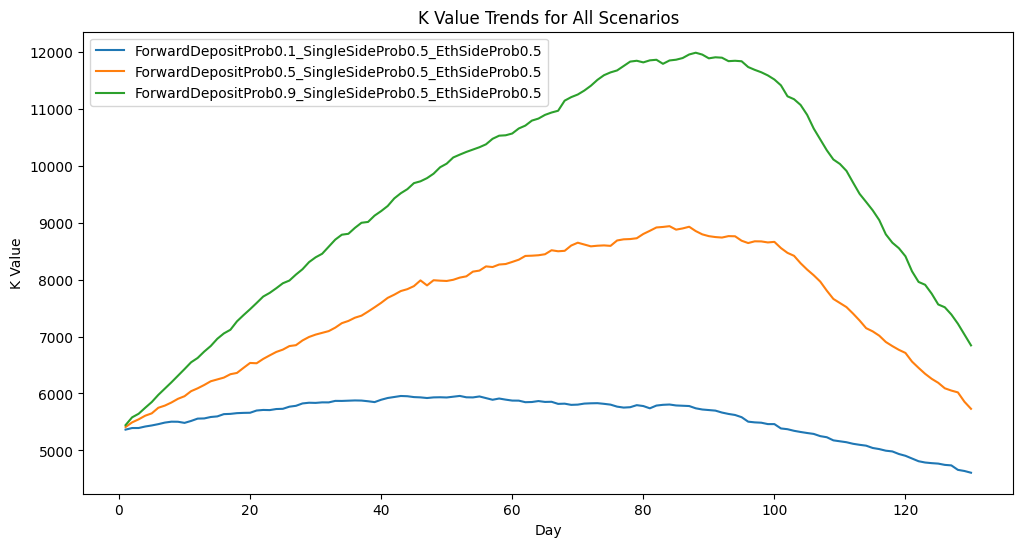

In [57]:
import random
import pandas as pd
from dyson_pool import DysonPool
import matplotlib.pyplot as plt
from price_loader import load_eth_prices
import os
import math

def simple_backtest(
    init_eth,
    init_usdc,
    main_days,
    deposit_count_each_day,
    forward_prob,
    single_side_prob,
    eth_side_prob,
    min_eth,
    max_eth,
    min_usdc,
    max_usdc,
    tag,
):
    pool = DysonPool(init_eth, init_usdc, basis=0.7, w_factor=1)
    deposits_df = pd.DataFrame(
        columns=["note_id", "day", "type", "in0", "in1", "withdraw_day"]
    )
    reverse_df = pd.DataFrame(
        columns=["note_id", "day", "type", "m", "n", "exercise_check_day"]
    )
    withdraws_df = pd.DataFrame(columns=["note_id", "day", "amt0", "amt1"])
    reverts_df = pd.DataFrame(
        columns=[
            "note_id",
            "day",
            "price_in",
            "price_out",
            "m",
            "n",
            "option_type",
            "swap_in",
            "swap_out",
        ]
    )
    snapshots = []

    # 統計計數器
    forward_count = 0
    reverse_count = 0
    forward_total_amount = 0.0
    reverse_total_amount = 0.0
    withdraw_count = 0
    revert_count = 0

    cool_down = 30
    total_days = main_days + cool_down

    prices_df = (
        load_eth_prices(total_days).drop_duplicates("date").reset_index(drop=True)
    )
    prices = prices_df["price_usd"]

    for day in range(1, total_days + 1):
        eth_price = prices[day - 1]

        if day <= main_days:
            for count in range(deposit_count_each_day):
                single = random.random() < single_side_prob
                if random.random() < forward_prob:
                    if single:
                        if random.random() < eth_side_prob:
                            in0 = round(random.uniform(min_eth, max_eth), 4)
                            in1 = 0
                        else:
                            in0 = 0
                            in1 = round(random.uniform(min_usdc, max_usdc), 2)
                    else:
                        in0 = round(random.uniform(min_eth, max_eth), 4)
                        in1 = round(random.uniform(min_usdc, max_usdc), 2)

                    nid = pool.deposit(in0, in1, eth_price)
                    withdraw_day = random.randint(day + 1, total_days)
                    deposits_df = pd.concat(
                        [
                            deposits_df,
                            pd.DataFrame(
                                [
                                    {
                                        "note_id": nid,
                                        "day": day,
                                        "type": "forward",
                                        "in0": in0,
                                        "in1": in1,
                                        "withdraw_day": withdraw_day,
                                    }
                                ]
                            ),
                        ],
                        ignore_index=True,
                    )
                    forward_count += 1
                    forward_total_amount += in0 * eth_price + in1
                else:
                    if single:
                        if random.random() < eth_side_prob:
                            m = round(random.uniform(min_eth, max_eth), 4)
                            n = 0
                        else:
                            m = 0
                            n = round(random.uniform(min_usdc, max_usdc), 2)
                    else:
                        m = round(random.uniform(min_eth, max_eth), 4)
                        n = round(random.uniform(min_usdc, max_usdc), 2)

                    nid = pool.reverse_deposit(m, n, eth_price)
                    exercise_day = random.randint(day + 1, total_days)
                    reverse_df = pd.concat(
                        [
                            reverse_df,
                            pd.DataFrame(
                                [
                                    {
                                        "note_id": nid,
                                        "day": day,
                                        "type": "reverse",
                                        "m": m,
                                        "n": n,
                                        "exercise_check_day": exercise_day,
                                    }
                                ]
                            ),
                        ],
                        ignore_index=True,
                    )
                    reverse_count += 1
                    reverse_total_amount += m * eth_price + n

        for index, dep in deposits_df.iterrows():
            if dep["withdraw_day"] == day:
                note, amt0, amt1 = pool.withdraw_due(eth_price, dep["note_id"])
                withdraws_df = pd.concat(
                    [
                        withdraws_df,
                        pd.DataFrame(
                            [
                                {
                                    "note_id": note.id,
                                    "day": day,
                                    "amt0": amt0,
                                    "amt1": amt1,
                                }
                            ]
                        ),
                    ],
                    ignore_index=True,
                )
                withdraw_count += 1

        for index, rev in reverse_df.iterrows():
            if rev["exercise_check_day"] == day:
                n = pool.notes_reverse.get(rev["note_id"])
                if n:
                    should_revert_put = n.m > 0 and eth_price > n.price_in
                    should_revert_call = n.n > 0 and eth_price < n.price_in
                    if should_revert_put or should_revert_call:
                        option_type = "put" if should_revert_put else "call"
                        _, swap_in, swap_out = pool.revert_exercise(
                            rev["note_id"], option_type
                        )
                        reverts_df = pd.concat(
                            [
                                reverts_df,
                                pd.DataFrame(
                                    [
                                        {
                                            "note_id": rev["note_id"],
                                            "day": day,
                                            "price_in": n.price_in,
                                            "price_out": eth_price,
                                            "m": n.m,
                                            "n": n.n,
                                            "option_type": option_type,
                                            "swap_in": swap_in,
                                            "swap_out": swap_out,
                                        }
                                    ]
                                ),
                            ],
                            ignore_index=True,
                        )
                        revert_count += 1

        snapshots.append(pool.snapshot(day, eth_price))

    snapshots_df = pd.DataFrame(snapshots)
    os.makedirs("results", exist_ok=True)
    snapshots_df.to_csv(f"results/snapshots_{tag}.csv", index=False)

    # 返回統計數據
    stats = {
        "forward_count": forward_count,
        "reverse_count": reverse_count,
        "forward_total_amount": forward_total_amount,
        "reverse_total_amount": reverse_total_amount,
        "withdraw_count": withdraw_count,
        "revert_count": revert_count,
    }

    return snapshots_df, stats


# 參數組合
main_days = 100
deposit_count_each_day = 10
min_eth, max_eth = 0.01, 0.5
min_usdc, max_usdc = 20, 2000
cool_down = 30
total_days = main_days + cool_down

# 交叉測試參數
forward_probs = [0.1, 0.5, 0.9]
single_side_probs = [0.5]
eth_side_probs = [0.5]

prices_df = load_eth_prices(total_days).drop_duplicates("date").reset_index(drop=True)

init_eth = 100
init_usdc = 100 * prices_df["price_usd"].iloc[0]
init_k = math.sqrt(init_eth * init_usdc)

os.makedirs("results", exist_ok=True)
plt.plot(range(1, total_days + 1), prices_df["price_usd"])
plt.title("ETH Price USD")
plt.xlabel("Day")
plt.ylabel("Price")
plt.savefig("results/price_trend.png")
plt.show()

all_snapshots = {}
for fp in forward_probs:
    for ssp in single_side_probs:
        for esp in eth_side_probs:
            tag = f"ForwardDepositProb{fp}_SingleSideProb{ssp}_EthSideProb{esp}"
            snapshots_df, stats = simple_backtest(
                init_eth,
                init_usdc,
                main_days,
                deposit_count_each_day,
                fp,
                ssp,
                esp,
                min_eth,
                max_eth,
                min_usdc,
                max_usdc,
                tag,
            )
            all_snapshots[tag] = snapshots_df

            # 列印每個測項的統計數據
            print(f"\n統計數據 - {tag}:")
            print(f"正向存款筆數: {stats['forward_count']}")
            print(f"反向存款筆數: {stats['reverse_count']}")
            print(f"正向存款總金額: {stats['forward_total_amount']:.2f} USD")
            print(f"反向存款總金額: {stats['reverse_total_amount']:.2f} USD")
            print(f"提領筆數: {stats['withdraw_count']}")
            print(f"revert_exercise 筆數: {stats['revert_count']}")

# 列印所有場景的 K 值變化
print("\n所有場景的 K 值變化:")
for tag, df in all_snapshots.items():
    final_k = df["k"].iloc[-1]
    change = (final_k - init_k) / init_k * 100
    print(f"{tag}: 初始 K = {init_k:.2f}, 最終 K = {final_k:.2f}, 變化 = {change:.2f}%")

# 繪製所有 K 值趨勢圖
plt.figure(figsize=(12, 6))
for tag, df in all_snapshots.items():
    plt.plot(range(1, total_days + 1), df["k"], label=tag)

plt.title("K Value Trends for All Scenarios")
plt.xlabel("Day")
plt.ylabel("K Value")
plt.legend()
plt.savefig("results/all_k_trends.png")
plt.show()